In [1]:
import os
import time
import numpy as np
from PIL import Image
import cv2
import matplotlib.pyplot as plt # 基础数据处理

from random import sample # 随机采样

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader # Pytorch
print(torch.__version__)

import torchvision
import torchvision.transforms as transforms

from tqdm import tqdm as tqdm


1.1.0


# Dataset & Dataloader & Preprocessing
For dataprocessing, the mean and std will be computed when init()

In [2]:
train_root = './train'
labels = os.listdir(train_root)


class DrawDataset(Dataset):
    def __init__(self, data_root = '',transform = None,anlysis = False):
        self.mean = 0.16443629118313927
        self.std = 0.3239202530511322
        self.transform = transform
        self.anlysis = False # only used when first computation
        self.label_mapper = {'airplane': 0, 'ant': 1, 'bear': 2, 'bird': 3, 'bridge': 4,
                        'bus'     : 5, 'calendar': 6, 'car': 7, 'chair': 8, 'dog': 9,
                        'dolphin' : 10, 'door': 11, 'flower': 12, 'fork': 13, 'truck': 14}
        self.IO_mapper = []
        for train_root in data_root:
            for x in self.label_mapper:
                print('loading class:',x,'in',train_root)
                temp_root = os.path.join(train_root,x)
                temp_list = os.listdir(temp_root)
                for img in temp_list:
                    full_str = os.path.join(temp_root,img)
                    self.IO_mapper.append([full_str , self.label_mapper[x]])
        print('Data loading finished,',len(self.IO_mapper),'totally')
        print('Data Cleaning Fire ON!!!')
        self.CleanIO_mapper = []
        for i in tqdm(range(0,len(self.IO_mapper))):
            figure = cv2.imread(self.IO_mapper[i][0],0)
            try:
                shape = figure.shape
            except:
#                 print('Oh, you can not really drawing~')
                continue
            else:
                if figure.shape != (28,28):
                    continue
                else:
                    self.CleanIO_mapper.append(self.IO_mapper[i])
#                     print('Oh, you can really drawing~')
        self.IO_mapper = self.CleanIO_mapper
        del self.CleanIO_mapper
        print('Data loading finished,',len(self.IO_mapper),'remaining')
        if anlysis:
            self.analysis()
    
    def __len__(self):
        return len(self.IO_mapper)
    
    def __getitem__(self,idx):
        image = cv2.imread(self.IO_mapper[idx][0],0)
        if self.transform is not None:
            image = self.transform(Image.fromarray(image))
        return image,self.IO_mapper[idx][1]
    
    def analysis(self):
        print('Data analysising……')
        self.mean = 0
        self.std = 0
        temp = []
        for i in tqdm(self):
            img = i[0].flatten() # 转为一维数组方便计算
            self.mean += np.sum(img)
        self.mean = self.mean / (len(self)*img.size)
        print('Mean:',self.mean)
        for i in self:
            img = i[0].flatten() # 转为一维数组方便计算
            self.std = self.std + np.sum((img - self.mean) ** 2)
        self.std = np.sqrt(self.std / (len(self)*img.size))
        print('Std:',self.std)


# Preprocessing
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0), ratio=(0.75, 1.33), interpolation=2), # resize+crop
    transforms.RandomAffine((-15,15), translate=(0.1,0.3),shear=(-5,5), fillcolor=0),
    transforms.RandomHorizontalFlip(p=0.3), # 30% 概率水平翻转
    transforms.RandomRotation((-10,10)), # 随机旋转
    torchvision.transforms.RandomPerspective(distortion_scale=0.3, p=0.3, interpolation=3),
    transforms.ToTensor(),
    transforms.Normalize((0.16443629118313927, ),(0.3239202530511322, )),
])

# Dataset & Dataloader
# Draws = DrawDataset(['./train','./extra_training_data/data'],transform = train_transform)
Draws = DrawDataset(['./train','./handwashed'],transform = train_transform)
# Draws = DrawDataset(['./train'],transform = train_transform) # original
dl = DataLoader(Draws, batch_size = 4, shuffle = True, num_workers = 8)


loading class: airplane in ./train
loading class: ant in ./train
loading class: bear in ./train


  0%|          | 0/10582 [00:00<?, ?it/s]

loading class: bird in ./train
loading class: bridge in ./train
loading class: bus in ./train
loading class: calendar in ./train
loading class: car in ./train
loading class: chair in ./train
loading class: dog in ./train
loading class: dolphin in ./train
loading class: door in ./train
loading class: flower in ./train
loading class: fork in ./train
loading class: truck in ./train
loading class: airplane in ./handwashed
loading class: ant in ./handwashed
loading class: bear in ./handwashed
loading class: bird in ./handwashed
loading class: bridge in ./handwashed
loading class: bus in ./handwashed
loading class: calendar in ./handwashed
loading class: car in ./handwashed
loading class: chair in ./handwashed
loading class: dog in ./handwashed
loading class: dolphin in ./handwashed
loading class: door in ./handwashed
loading class: flower in ./handwashed
loading class: fork in ./handwashed
loading class: truck in ./handwashed
Data loading finished, 10582 totally
Data Cleaning Fire ON!!!


100%|██████████| 10582/10582 [00:01<00:00, 6456.21it/s]

Data loading finished, 10161 remaining


In [3]:
a = cv2.imread(Draws.IO_mapper[0][0],0).shape
print(a)

(28, 28)


# Show Images & Labels

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


airplane ant bear flower 


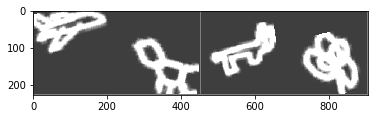

In [4]:
def imshow(img):
    img = img/2 + 0.5 # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg,(1,2,0)))

dataiter = iter(dl)
images,labels = dataiter.next()

k = list(Draws.label_mapper.keys()) # [1,2,3,5,4]
v = list(Draws.label_mapper.values()) #[3,5,2,1,1]
imshow(torchvision.utils.make_grid(images))

labelshow = ''
for i in labels:
    labelshow += k[v.index(i)] + ' '
print(labelshow)

# Training

In [5]:
import torch.nn as nn

# Hyperparameters
RANDOM_SEED = 1
LEARNING_RATE = 5e-3
WEIGHT_DECAY = 0.0001
BATCH_SIZE = 512
NUM_EPOCHS = 200
# NUM_EPOCHS = 200

# Architecture
NUM_FEATURES = 224*224
NUM_CLASSES = 15

# Other
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
GRAYSCALE = True
print('We will implement this model on:',DEVICE,'!')

# for server-1
# Datasets
trainset = Draws

# DataLoader

trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle = True, num_workers = 8)

classes = ['airplane', 'ant', 'bear', 'bird', 'bridge',
                        'bus', 'calendar', 'car', 'chair', 'dog',
                        'dolphin', 'door', 'flower', 'fork', 'truck']

# Checking datasets
for images, labels in trainloader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break


We will implement this model on: cuda !
Image batch dimensions: torch.Size([512, 1, 224, 224])
Image label dimensions: torch.Size([512])


In [6]:
def conv_bn(inp, oup, stride, conv_layer=nn.Conv2d, norm_layer=nn.BatchNorm2d, nlin_layer=nn.ReLU):
    return nn.Sequential(
        conv_layer(inp, oup, 3, stride, 1, bias=False),
        norm_layer(oup),
        nlin_layer(inplace=True)
    )


def conv_1x1_bn(inp, oup, conv_layer=nn.Conv2d, norm_layer=nn.BatchNorm2d, nlin_layer=nn.ReLU):
    return nn.Sequential(
        conv_layer(inp, oup, 1, 1, 0, bias=False),
        norm_layer(oup),
        nlin_layer(inplace=True)
    )


class Hswish(nn.Module):
    def __init__(self, inplace=True):
        super(Hswish, self).__init__()
        self.inplace = inplace

    def forward(self, x):
        return x * F.relu6(x + 3., inplace=self.inplace) / 6.


class Hsigmoid(nn.Module):
    def __init__(self, inplace=True):
        super(Hsigmoid, self).__init__()
        self.inplace = inplace

    def forward(self, x):
        return F.relu6(x + 3., inplace=self.inplace) / 6.


class SEModule(nn.Module):
    def __init__(self, channel, reduction=4):
        super(SEModule, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            Hsigmoid()
            # nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)


class Identity(nn.Module):
    def __init__(self, channel):
        super(Identity, self).__init__()

    def forward(self, x):
        return x


def make_divisible(x, divisible_by=8):
    import numpy as np
    return int(np.ceil(x * 1. / divisible_by) * divisible_by)


class MobileBottleneck(nn.Module):
    def __init__(self, inp, oup, kernel, stride, exp, se=False, nl='RE'):
        super(MobileBottleneck, self).__init__()
        assert stride in [1, 2]
        assert kernel in [3, 5]
        padding = (kernel - 1) // 2
        self.use_res_connect = stride == 1 and inp == oup

        conv_layer = nn.Conv2d
        norm_layer = nn.BatchNorm2d
        if nl == 'RE':
            nlin_layer = nn.ReLU # or ReLU6
        elif nl == 'HS':
            nlin_layer = Hswish
        else:
            raise NotImplementedError
        if se:
            SELayer = SEModule
        else:
            SELayer = Identity

        self.conv = nn.Sequential(
            # pw
            conv_layer(inp, exp, 1, 1, 0, bias=False),
            norm_layer(exp),
            nlin_layer(inplace=True),
            # dw
            conv_layer(exp, exp, kernel, stride, padding, groups=exp, bias=False),
            norm_layer(exp),
            SELayer(exp),
            nlin_layer(inplace=True),
            # pw-linear
            conv_layer(exp, oup, 1, 1, 0, bias=False),
            norm_layer(oup),
        )

    def forward(self, x):
        if self.use_res_connect:
            return x + self.conv(x)
        else:
            return self.conv(x)


class MobileNetV3(nn.Module):
    def __init__(self, n_class=1000, input_size=224, dropout=0.8, mode='small', width_mult=1.0):
        super(MobileNetV3, self).__init__()
        input_channel = 16
        last_channel = 1280
        if mode == 'large':
            # refer to Table 1 in paper
            mobile_setting = [
                # k, exp, c,  se,     nl,  s,
                [3, 16,  16,  False, 'RE', 1],
                [3, 64,  24,  False, 'RE', 2],
                [3, 72,  24,  False, 'RE', 1],
                [5, 72,  40,  True,  'RE', 2],
                [5, 120, 40,  True,  'RE', 1],
                [5, 120, 40,  True,  'RE', 1],
                [3, 240, 80,  False, 'HS', 2],
                [3, 200, 80,  False, 'HS', 1],
                [3, 184, 80,  False, 'HS', 1],
                [3, 184, 80,  False, 'HS', 1],
                [3, 480, 112, True,  'HS', 1],
                [3, 672, 112, True,  'HS', 1],
                [5, 672, 160, True,  'HS', 2],
                [5, 960, 160, True,  'HS', 1],
                [5, 960, 160, True,  'HS', 1],
            ]
        elif mode == 'small':
            # refer to Table 2 in paper
            mobile_setting = [
                # k, exp, c,  se,     nl,  s,
                [3, 16,  16,  True,  'RE', 2],
                [3, 72,  24,  False, 'RE', 2],
                [3, 88,  24,  False, 'RE', 1],
                [5, 96,  40,  True,  'HS', 2],
                [5, 240, 40,  True,  'HS', 1],
                [5, 240, 40,  True,  'HS', 1],
                [5, 120, 48,  True,  'HS', 1],
                [5, 144, 48,  True,  'HS', 1],
                [5, 288, 96,  True,  'HS', 2],
                [5, 576, 96,  True,  'HS', 1],
                [5, 576, 96,  True,  'HS', 1],
            ]
        else:
            raise NotImplementedError

        # building first layer
        assert input_size % 32 == 0
        last_channel = make_divisible(last_channel * width_mult) if width_mult > 1.0 else last_channel
        self.features = [conv_bn(1, input_channel, 2, nlin_layer=Hswish)]
        self.classifier = []

        # building mobile blocks
        for k, exp, c, se, nl, s in mobile_setting:
            output_channel = make_divisible(c * width_mult)
            exp_channel = make_divisible(exp * width_mult)
            self.features.append(MobileBottleneck(input_channel, output_channel, k, s, exp_channel, se, nl))
            input_channel = output_channel

        # building last several layers
        if mode == 'large':
            last_conv = make_divisible(960 * width_mult)
            self.features.append(conv_1x1_bn(input_channel, last_conv, nlin_layer=Hswish))
            self.features.append(nn.AdaptiveAvgPool2d(1))
            self.features.append(nn.Conv2d(last_conv, last_channel, 1, 1, 0))
            self.features.append(Hswish(inplace=True))
        elif mode == 'small':
            last_conv = make_divisible(576 * width_mult)
            self.features.append(conv_1x1_bn(input_channel, last_conv, nlin_layer=Hswish))
            # self.features.append(SEModule(last_conv))  # refer to paper Table2, but I think this is a mistake
            self.features.append(nn.AdaptiveAvgPool2d(1))
            self.features.append(nn.Conv2d(last_conv, last_channel, 1, 1, 0))
            self.features.append(Hswish(inplace=True))
        else:
            raise NotImplementedError

        # make it nn.Sequential
        self.features = nn.Sequential(*self.features)

        # building classifier
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout),    # refer to paper section 6
            nn.Linear(last_channel, n_class),
        )

        self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = x.mean(3).mean(2)
        logits = self.classifier(x)
        probas = F.softmax(logits, dim=1)
        return logits, probas

    def _initialize_weights(self):
        # weight initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)


def mobilenetv3(pretrained=False, **kwargs):
    model = MobileNetV3(**kwargs)
    if pretrained:
        state_dict = torch.load('mobilenetv3_small_67.4.pth.tar')
        model.load_state_dict(state_dict, strict=True)
        # raise NotImplementedError
    return model




In [7]:
model = mobilenetv3(n_class = NUM_CLASSES,input_size=224, dropout=0.8, mode='small', width_mult=1.0)
torch.manual_seed(RANDOM_SEED)
model.to(DEVICE)
if(DEVICE == 'cuda'):
    model=torch.nn.DataParallel(model)



In [8]:
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=10, verbose=True, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=5e-06)

import time
import torch.nn.functional as F
def compute_accuracy(model, data_loader, device):
    correct_pred, num_examples = 0, 0
    for i, (features, targets) in enumerate(data_loader):
            
        features = features.to(device)
        targets = targets.to(device)

        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100
    

start_time = time.time()
for epoch in range(0, NUM_EPOCHS):
    
    model.train()
    for batch_idx, (features, targets) in enumerate(trainloader):
        
        features = features.to(DEVICE)
        targets = targets.to(DEVICE)
            
        ### FORWARD AND BACK PROP
        logits, probas = model(features)
        cost = F.cross_entropy(logits, targets)
        optimizer.zero_grad()
#         scheduler.zero_grad()
        cost.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        ### LOGGING
        if not batch_idx % 70:
            print ('Epoch: %03d/%03d | Batch %04d/%04d | Cost: %.4f' 
                   %(epoch+1, NUM_EPOCHS, batch_idx, 
                     len(trainloader), cost))

        

    model.eval()
    with torch.set_grad_enabled(False): # save memory during inference
        now_acc = compute_accuracy(model, trainloader, device=DEVICE)
        print('Epoch: %03d/%03d | Train: %.3f%%' % (
              epoch+1, NUM_EPOCHS, 
              now_acc))
        scheduler.step(now_acc)

    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))


with torch.set_grad_enabled(False): # save memory during inference
    print('Test accuracy: %.2f%%' % (compute_accuracy(model, trainloader, device=DEVICE)))
    
print('Total Time: %.2f min' % ((time.time() - start_time)/60))



def save_model(the_model, PATH = 'final.pkl'):
    torch.save(the_model.module.state_dict(), PATH)


    
save_model(model,'mov3.pkl')


Epoch: 001/200 | Batch 0000/0020 | Cost: 2.7167
Epoch: 001/200 | Train: 6.692%
Time elapsed: 0.49 min
Epoch: 002/200 | Batch 0000/0020 | Cost: 2.0016
Epoch: 002/200 | Train: 11.150%
Time elapsed: 0.77 min
Epoch: 003/200 | Batch 0000/0020 | Cost: 1.7706
Epoch: 003/200 | Train: 49.188%
Time elapsed: 1.06 min
Epoch: 004/200 | Batch 0000/0020 | Cost: 1.4702
Epoch: 004/200 | Train: 43.382%
Time elapsed: 1.42 min
Epoch: 005/200 | Batch 0000/0020 | Cost: 1.2790
Epoch: 005/200 | Train: 62.100%
Time elapsed: 1.78 min
Epoch: 006/200 | Batch 0000/0020 | Cost: 1.1426
Epoch: 006/200 | Train: 58.055%
Time elapsed: 2.12 min
Epoch: 007/200 | Batch 0000/0020 | Cost: 1.0063
Epoch: 007/200 | Train: 55.989%
Time elapsed: 2.35 min
Epoch: 008/200 | Batch 0000/0020 | Cost: 0.9500
Epoch: 008/200 | Train: 66.519%
Time elapsed: 2.62 min
Epoch: 009/200 | Batch 0000/0020 | Cost: 0.9478
Epoch: 009/200 | Train: 70.052%
Time elapsed: 2.91 min
Epoch: 010/200 | Batch 0000/0020 | Cost: 0.9153
Epoch: 010/200 | Train: 69

In [9]:
def save_model(the_model, PATH = 'mov3.pkl'):
    torch.save(the_model.module.state_dict(), PATH)


    
save_model(model,'mov3.pkl')


# Inference
## Load model

In [11]:
# model_loader



def load_model(PATH = 'mov3.pkl'):
    test_model = mobilenetv3(n_class = NUM_CLASSES,input_size=224, dropout=0.8, mode='small', width_mult=1.0)
    test_model.load_state_dict(torch.load(PATH))
    return test_model


test_model = load_model('mov3.pkl')

torch.manual_seed(RANDOM_SEED)

test_model.to(DEVICE)
if(DEVICE == 'cuda'):
    test_model=torch.nn.DataParallel(test_model)

test_model.eval() #




DataParallel(
  (module): MobileNetV3(
    (features): Sequential(
      (0): Sequential(
        (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Hswish()
      )
      (1): MobileBottleneck(
        (conv): Sequential(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace)
          (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (5): SEModule(
            (avg_pool): AdaptiveAvgPool2d(output_size=1)
            (fc): Sequential(
              (0): Linear(in_features=16, out_features=4, bias=False)
              (1): ReLU(inplace)
              (2): Linear

# TestDataSet & DataLoader

In [12]:
class TestDataset(Dataset):
    def __init__(self, data_root = '',transform = None):
        self.mean = 0.16443629118313927
        self.std = 0.3239202530511322
        self.transform = transform
        self.label_mapper = {'airplane': 0, 'ant': 1, 'bear': 2, 'bird': 3, 'bridge': 4,
                        'bus'     : 5, 'calendar': 6, 'car': 7, 'chair': 8, 'dog': 9,
                        'dolphin' : 10, 'door': 11, 'flower': 12, 'fork': 13, 'truck': 14}
        self.IO_mapper = []
        self.picids = []
        temp_list = os.listdir(data_root)
        for img in temp_list:
            self.picids.append(img.split('.')[0])
            full_str = os.path.join(data_root,img)
            
            
            self.IO_mapper.append(full_str)
        print('Data loading finished,',len(self.IO_mapper),'totally')
    
    def __len__(self):
        return len(self.IO_mapper)
    
    def __getitem__(self,idx):
        image = cv2.imread(self.IO_mapper[idx],0)
        picid = self.picids[idx]
        if self.transform is not None:
            image = self.transform(Image.fromarray(image))
        return picid, image

# Preprocessing
test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.16443629118313927, ),(0.3239202530511322, )),
])
test_root = './released_test'
# Dataset & Dataloader
TestD = TestDataset(test_root, transform = test_transform)
Testdl = DataLoader(TestD, batch_size = 1024, shuffle = True, num_workers = 8)


Data loading finished, 45000 totally


# Do inference & writing csv file

In [13]:
import csv

import time
import torch.nn.functional as F
def compute_accuracy(model, data_loader, device):
    correct_pred, num_examples = 0, 0
    for i, (features, targets) in enumerate(data_loader):
            
        features = features.to(device)
        targets = targets.to(device)

        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100
    

start_time = time.time()
pics = []
labels = []
with torch.set_grad_enabled(False): 
    for i, (picids,features) in tqdm(enumerate(Testdl)):
        features = features.to(DEVICE)
        picids = list(picids)
        logits, probas = test_model(features)
        _, predicted_labels = torch.max(probas, 1)
        predicted_labels = list(predicted_labels.cpu().numpy())
        pics += picids
        labels += predicted_labels
    print(len(pics),len(labels))
    
headers = ['id','categories']

with open('019033910029.csv','w')as f:
    f_csv = csv.writer(f)
    f_csv.writerow(headers)
    for i in tqdm(range(0,len(pics))):
        f_csv.writerow([int(pics[i]),int(labels[i])])


44it [00:10,  4.73it/s]
100%|██████████| 45000/45000 [00:00<00:00, 866253.67it/s]

45000 45000
